# First part


## Preparations

Loading the modules:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

Reading the data into a pandas dataframe and having a first look:

In [3]:
df = pd.read_csv("data/data.csv", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9
0,2.12532,-8.35859,-9.39368,8.56843,8.78855,6.32030,-4.73014,-6.92553,3.68487,-1.20625
1,-10.15949,9.97078,8.04821,-4.82858,-6.30387,-6.97885,-3.21693,0.88861,-0.46591,-3.54025
2,-2.50408,8.77970,3.22451,1.55252,-7.22234,-7.68239,-8.99961,7.72757,3.90849,4.33603
3,-7.33024,-1.95436,-8.70898,8.48457,-4.18574,4.30856,-3.39816,0.54945,0.05314,-7.01513
4,-10.05601,9.74470,6.60193,-5.27618,-6.28668,-7.61490,-2.91889,0.00137,-2.91768,-4.60353


Normalizing the data:

In [4]:
df = (df - df.mean()) / df.std()
df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.304724,-1.054323,-1.025863,-0.039866,1.382697,0.600570,-0.061598,-0.846071,0.804463,0.115472
1,-1.387043,1.204223,0.982297,-0.050219,-0.795629,-1.303596,0.182137,0.234281,0.162984,-0.205579
2,-0.332800,1.057458,0.426924,-0.045288,-0.928194,-1.404328,-0.749289,1.179808,0.839022,0.877837
3,-0.997421,-0.265194,-0.947031,-0.039931,-0.489914,0.312530,0.152946,0.187390,0.243200,-0.683564
4,-1.372793,1.176365,0.815781,-0.050565,-0.793148,-1.394665,0.230143,0.111614,-0.215923,-0.351838


## Finding the number of clusters

To find a reasonable amount of clusters, we are going to fit GMM for all possible number of clusters, and then calculate the Silhouette Score for each of them.

The closer to 1 the score, the better the model.

In [5]:
# Parameters

# Valid parameters for number of clusters are from 2 to n_samples - 1 (inclusive)
num_of_clusters_range = np.arange(2, len(df)).tolist()

# For reproducibility
random_seed = 42

# Init method of choice
method="k-means++"
n_init = 1 # default setting for k-means++ in version 1.2

X = df.values # converting pandas dataframe to numpy matrix to use it with scikit GMM

results = {} # dict with num_of_clusters as a key and labels as a value
silhouette_avg = [] # avg silhouette score for every number of clusters

Calculating average silhouette score for every clustering:

In [6]:
for num_of_clusters in num_of_clusters_range:
    gm = GaussianMixture(
        n_components=num_of_clusters,
        init_params=method,
        n_init=n_init,
        random_state=random_seed,
    )
    cluster_labels = gm.fit_predict(X)
    results[num_of_clusters] = pd.DataFrame(
        data=cluster_labels,
        columns=["cluster"],
        index=df.index,
    )

    silhouette_avg.append(silhouette_score(X, cluster_labels))

Comparing the results for different number of clusters:

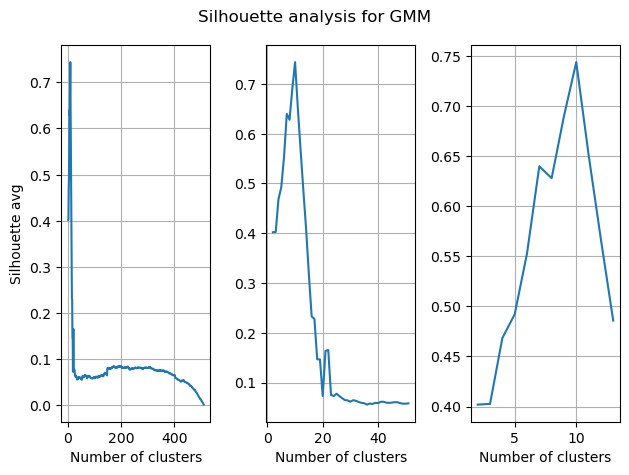

In [7]:
fig, axs = plt.subplots(1, 3)

axs[0].set(ylabel="Silhouette avg")

for ax, scale in zip(axs, [512, 50, 12]):
    ax.plot(num_of_clusters_range[:scale], silhouette_avg[:scale])
    ax.set(xlabel="Number of clusters")
    ax.grid()

fig.suptitle("Silhouette analysis for GMM")
fig.tight_layout()

plt.show()

As we can see, the best number of clusters is **10**, according to silhouette analysis, with a score of:

In [8]:
max(silhouette_avg)

0.7436908500057196

## Checking the results


Let's see what are the results of the clustering

In [9]:
clusters = results[10]
colors = clusters.values
clusters.groupby(["cluster"]).size().reset_index(name="counts")

,cluster,counts
0,0,63
1,1,64
2,2,1
3,3,64
4,4,64
5,5,63
6,6,1
7,7,64
8,8,64
9,9,64


As we can see, 8 of 10 clusters are almost the same, and two clusters having only 1 elements.

Let's take a look on it in two dimensions

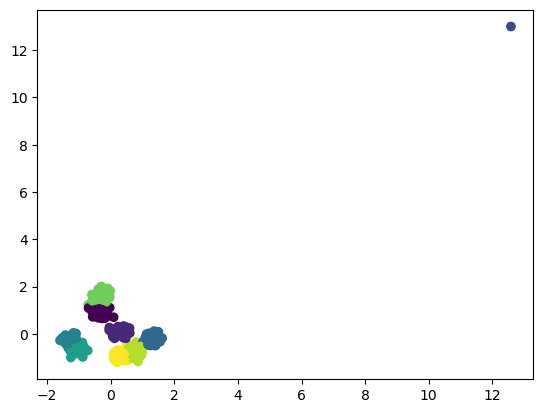

In [10]:
# 0 & 9 dimensions were selected empirically as best for demonstration
plt.scatter(*X[:, (0, 9)].T, c=colors)

And now let's remove two outliers to have a "zoom in"

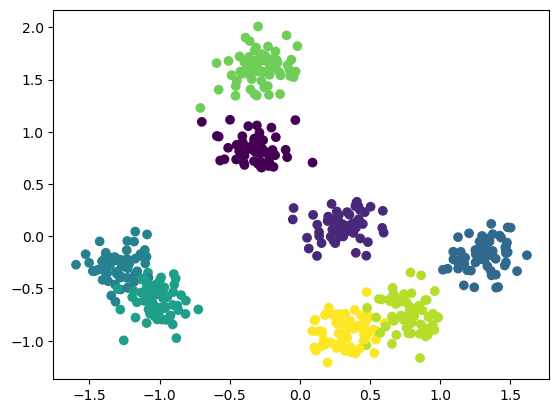

In [11]:
lonely_rows = clusters[clusters.cluster.isin([2, 6])]

X_filtered = np.delete(X, lonely_rows.index.tolist(), axis=0)
colors_filtered = np.delete(colors, lonely_rows.index.tolist())

plt.scatter(*X_filtered[:, (0, 9)].T, c=colors_filtered)
